# Data pre-processing

First, load required packages:

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# for fix activity data
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sympy import Symbol,expand

from IPython.display import HTML
from matplotlib import animation


import re
import glob

import statistics

import matplotlib.dates as mdates
import matplotlib.ticker as mticker



## Activity data
### load data

In [29]:
activity_data = np.load("./data/activity_list_full_flock_bbox_radius.npy")

Text(0.5, 1.0, 'Activity index 21-09 to 20-11')

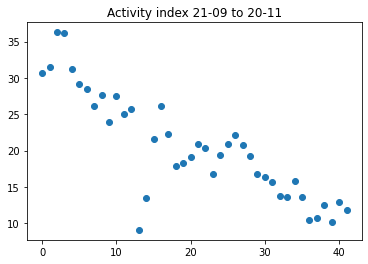

In [30]:
daily_activity = np.mean(activity_data.reshape(-1, 1440), axis=1) # 1440 min per day
plt.scatter(np.arange(0,len(daily_activity)),daily_activity)
plt.title("Activity index 21-09 to 20-11")

### Fix corrupted data by polyfit

In [31]:
# assign index (day number) to activity data
idx_daily = np.arange(len(daily_activity))
activity_df = pd.DataFrame(daily_activity,idx_daily)
activity_df = activity_df.drop([13,14])
activity_df.columns=['activity']

Best degree 5 with RMSE 1.8306173386435247


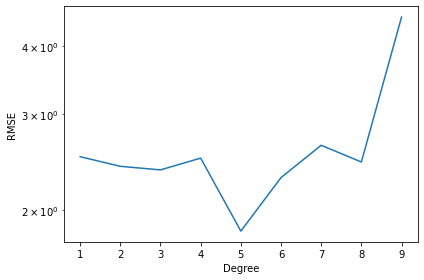

In [32]:
# ref
# https://stackoverflow.com/questions/47442102/how-to-find-the-best-degree-of-polynomials

y = np.array(activity_df["activity"])
X = np.array(activity_df.reset_index().index).reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=111)

rmses = []
degrees = np.arange(1, 10)
min_rmse, min_deg = 1e10, 0

for deg in degrees:

    # Train features
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    x_poly_train = poly_features.fit_transform(x_train)

    # Linear regression
    poly_reg = LinearRegression()
    poly_reg.fit(x_poly_train, y_train)

    # Compare with test data
    x_poly_test = poly_features.fit_transform(x_test)
    poly_predict = poly_reg.predict(x_poly_test)
    poly_mse = mean_squared_error(y_test, poly_predict)
    poly_rmse = np.sqrt(poly_mse)
    rmses.append(poly_rmse)
    
    # Cross-validation of degree
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg

# Plot and present results
print('Best degree {} with RMSE {}'.format(min_deg, min_rmse))
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(degrees, rmses)
ax.set_yscale('log')
ax.set_xlabel('Degree')
ax.set_ylabel('RMSE')
plt.tight_layout()
# plt.savefig("poly_activity.png",facecolor='white', edgecolor='none')

In [33]:
fit_act = np.polyfit(np.array(activity_df.reset_index().index),activity_df["activity"],5)
y1=np.poly1d(fit_act)
print(y1)
x=Symbol('a')
print(expand(y1(x)))

           5             4           3          2
9.006e-06 x - 0.0008814 x + 0.03017 x - 0.4149 x + 1.248 x + 31.92
9.00567952283168e-6*a**5 - 0.000881380835577706*a**4 + 0.0301726361501062*a**3 - 0.414945049688456*a**2 + 1.24776912387325*a + 31.9191407099722


In [34]:
# activity for day 13
a = 13
activity_fill = 9.00567952283168e-6*a**5 - 0.000881380835577706*a**4 + 0.0301726361501062*a**3 - 0.414945049688456*a**2 + 1.24776912387325*a + 31.9191407099722

print(activity_fill)

22.474335266894578


In [35]:
# activity for day 14
a=14
activity_fill = 9.00567952283168e-6*a**5 - 0.000881380835577706*a**4 + 0.0301726361501062*a**3 - 0.414945049688456*a**2 + 1.24776912387325*a + 31.9191407099722
print(activity_fill)
# 22.474335266894578
# 21.83673670528601

21.83673670528601


In [36]:
# put day 13, 14 data back
daily_activity[13]=float(22.474335266894578)
daily_activity[14]=float(21.83673670528601)

## Temperature & Humidity

In [37]:
input_21Sep=pd.read_csv("data/21Sep_summary.csv",header=2,dayfirst=True) #ASK109 folder in original data

Reduce original data to only necessary columns: 

In [38]:
input_21Sep = input_21Sep[["O/B's","Unnamed: 6","Unnamed: 7","Unnamed: 8","Unnamed: 11","Unnamed: 18"]]
input_21Sep.columns = ["Date","Mortality Rate", "Mortality", "Guideline Average Shed Temperature", "Water Usage(L)", "Feed Usage(grms/bird)"]
input_21Sep.Date = pd.to_datetime(input_21Sep.Date, dayfirst=True)
input_21Sep = input_21Sep.replace('#VALUE!', np.nan)
input_21Sep.head()

,Date,Mortality Rate,Mortality,Guideline Average Shed Temperature,Water Usage(L),Feed Usage(grms/bird)
0,2020-09-21,0.00%,0,33.0,0,NaN
1,2020-09-22,0.13%,16,32.4,14,NaN
2,2020-09-23,0.16%,36,31.8,19,NaN
3,2020-09-24,0.25%,68,31.2,29,2
4,2020-09-25,0.03%,72,30.8,39,NaN


Water and feed usage are low in the first few days because farmers would ditribute them on the ground all over the shed.

In [39]:
input_21Sep["Mortality Rate"] = input_21Sep["Mortality Rate"].str.rstrip("%").astype("float")/ 100.0
input_21Sep["Mortality"] = input_21Sep["Mortality"].astype("float")
input_21Sep["Guideline Average Shed Temperature"] = input_21Sep["Guideline Average Shed Temperature"].astype("float")
input_21Sep["Water Usage(L)"] = input_21Sep["Water Usage(L)"].astype("float")
input_21Sep["Feed Usage(grms/bird)"] = input_21Sep["Feed Usage(grms/bird)"].astype("float")

### load all files and construct big THI dataframe

In [40]:
# might take a few second
df0 = pd.read_csv("data/HumidTemp/mench-siteb-house2 03.csv")

df0['Timestamp']= pd.to_datetime(df0['Timestamp'])
# add the sensor beacon ID to the "Timestamp" column name
df0=df0.rename(columns = {'Timestamp':'Timestamp'+re.findall(r'\d\d',"data/HumidTemp/mench-siteb-house2 03.csv")[0]})

# start from 1 because already read 1 file
for i in glob.glob('data/HumidTemp/*.csv')[1:]:
    df1 = pd.read_csv(i)
    
    df1['Timestamp']= pd.to_datetime(df1['Timestamp'])
    
#     get previous file name because want to compare the earliest timestamp
    prev_filename = glob.glob('data/HumidTemp/*.csv')[glob.glob('data/HumidTemp/*.csv').index(i)-1]
    
#     find the sensor ID (the final two digits in file names), get earliest timestamp in that sensor/file
#     compare earliest time
#     if the previous file(s) has earlier time 
# (keep in mind for loop make the dataframe big and now it may have many timestamps and data from many files that are already read)
    if df0['Timestamp'+re.findall(r'\d\d',prev_filename)[0]].min() <= df1['Timestamp'].min():
        dftimestamp_later = df1['Timestamp'].min()
        df0 = df0[df0['Timestamp'+re.findall(r'\d\d',prev_filename)[0]]>=dftimestamp_later].reset_index(drop=True)

    else:
#         drop everything before the common timestamp in the file that has earlier time
        dftimestamp_later = df0['Timestamp'+re.findall(r'\d\d',prev_filename)[0]].min()
        df1 = df1[df1["Timestamp"]>=dftimestamp_later].reset_index(drop=True)

#         now both df has the same timestamp
    df_fin = pd.concat((df0,df1),axis=1)
#     change the column name of the latest added column to add the latest file name
    df_fin=df_fin.rename(columns = {'Timestamp':'Timestamp'+re.findall(r'\d\d',i)[0]})
# make the final df the new df to be checked in the next iteration
    df0=df_fin
    

df_fin.head()


,Timestamp03,Temperature (°C),Relative Humidity (%),Timestamp05,Temperature (°C),Relative Humidity (%),Timestamp06,Temperature (°C),Relative Humidity (%),Timestamp07,...,Relative Humidity (%),Timestamp15,Temperature (°C),Relative Humidity (%),Timestamp16,Temperature (°C),Relative Humidity (%),Timestamp18,Temperature (°C),Relative Humidity (%)
0,2020-10-03 14:44:00,24.5667,73.68,2020-10-03 14:44:00,17.8889,73.74,2020-10-03 14:44:00,26.8611,78.59,2020-10-03 14:44:00,...,69.26,2020-10-03 14:44:00,24.8167,67.61,2020-10-03 14:44:00,24.6111,67.43,2020-10-03 14:44:00,23.9333,69.90
1,2020-10-03 14:45:00,24.6444,73.22,2020-10-03 14:45:00,17.9000,73.71,2020-10-03 14:45:00,26.9389,74.51,2020-10-03 14:45:00,...,69.47,2020-10-03 14:45:00,24.7944,66.81,2020-10-03 14:45:00,24.6222,67.49,2020-10-03 14:45:00,23.9778,69.96
2,2020-10-03 14:46:00,24.6944,72.43,2020-10-03 14:46:00,17.9056,73.68,2020-10-03 14:46:00,27.7833,73.86,2020-10-03 14:46:00,...,69.20,2020-10-03 14:46:00,24.7833,67.12,2020-10-03 14:46:00,24.6333,67.30,2020-10-03 14:46:00,24.0222,69.78
3,2020-10-03 14:47:00,24.7167,72.16,2020-10-03 14:47:00,17.9056,73.68,2020-10-03 14:47:00,28.3889,66.78,2020-10-03 14:47:00,...,69.29,2020-10-03 14:47:00,24.7722,67.27,2020-10-03 14:47:00,24.6444,67.55,2020-10-03 14:47:00,24.0556,70.42
4,2020-10-03 14:48:00,24.7722,73.07,2020-10-03 14:48:00,17.9167,73.62,2020-10-03 14:48:00,28.3889,65.23,2020-10-03 14:48:00,...,69.62,2020-10-03 14:48:00,24.7500,67.33,2020-10-03 14:48:00,24.6667,67.70,2020-10-03 14:48:00,24.1389,69.96


In [41]:
# for recovery of the dataframe if made mistakes
df_fin_copy = df_fin
# df_fin = df_fin_copy

In [42]:
# drop all timestamp column but one, since all timestamps are consistent across sensors
df_fin_time = df_fin.iloc[:, 0] 

df_fin = df_fin.drop((df_fin.filter(regex='Timestamp')).columns, axis = 1)

df_fin.insert(0, column='Timestamp', value=df_fin_time)

Sensor 06 (third column) has the last day data missing

In [43]:
#calc average , min, max, med temp
# reduced to only 8 entries temp&hum per day
df_daily = df_fin.resample('D', on='Timestamp').mean().reset_index()


column_names = ['Average Temperature','Median Temperature','Min Temperature','Max Temperature',
               'Average Humidity','Median Humidity','Min Humidity','Max Humidity']
regex_for_original = ['Temperature','Temperature','Temperature','Temperature',
                      'Humidity','Humidity','Humidity','Humidity']
operations = [statistics.mean, statistics.median,min,max,statistics.mean, statistics.median,min,max]
for i,j,k in zip(column_names,regex_for_original,operations):
    df_daily.insert(1, column=i, 
                      value=pd.DataFrame(df_daily.filter(regex=j).values).apply(k, axis =1))

df_daily = df_daily.loc[:, :'Average Temperature']

In [44]:
# idea is to visualise how the temp and humid are changing throughout the day, taking into account spatial view
# not implemented

# df_spatial = df_fin.resample('D', on='Timestamp').mean().reset_index()

# column_names = ['Average Temperature','Median Temperature','Min Temperature','Max Temperature',
#                'Average Humidity','Median Humidity','Min Humidity','Max Humidity']
# regex_for_original = ['Temperature','Temperature','Temperature','Temperature',
#                       'Humidity','Humidity','Humidity','Humidity']
# operations = [statistics.mean, statistics.median,min,max,statistics.mean, statistics.median,min,max]
# for i,j,k in zip(column_names,regex_for_original,operations):
#     df_spatial.insert(1, column=i, value=pd.DataFrame(df_spatial.filter(regex=j).values).apply(k, axis =0))

# df_spatial = df_spatial.loc[:, :'Average Temperature']

In [45]:
# df_fin.resample('D', on='Timestamp').mean().reset_index().iloc[1].drop("Timestamp").plot()

Now we have daily temp and humid range
Now aggregate the guideline temp with actual ones: 

### Guideline Temp vs actual

FLOCK 1: 21/09/20 - 20/11/20

In [46]:
f1 = df_daily.loc[(df_daily["Timestamp"]>="2020-09-21") & (df_daily["Timestamp"]<="2020-11-20")][['Timestamp','Average Temperature']]
f1_temp = pd.merge(input_21Sep[["Date","Guideline Average Shed Temperature"]], f1, left_on="Date", right_on="Timestamp", how = "left").drop("Timestamp",axis=1)

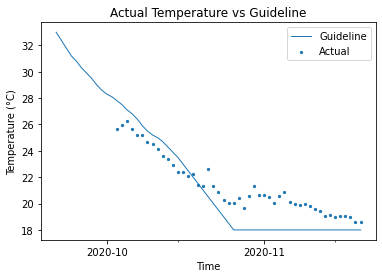

In [47]:
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# ax.tick_params(pad=10)

ax.xaxis.set_major_locator((mdates.MonthLocator()))
ax.xaxis.set_minor_locator((mdates.MonthLocator(bymonthday=15))) # x tick every half month

plt.plot(f1_temp.Date, f1_temp['Guideline Average Shed Temperature'], linewidth=1, label="Guideline")
plt.scatter(f1_temp.Date, f1_temp['Average Temperature'], s = 5, label = "Actual")
plt.title("Actual Temperature vs Guideline")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show() 
# plt.savefig("Actual_Guide_temp.png",facecolor="white", edgecolor='none')

Actual temperature varies from guideline, where (15-10-2020, 24 days ) the actual temp is higher than guideline. 

earlier half is lower than guideline, later half hotter. 

### Calculating THI

Formula for wet bulb temp:

Tw = T * arctan[0.151977 * (rh% + 8.313659)^(1/2)] + arctan(T + rh%) - arctan(rh% - 1.676331) + 0.00391838 *(rh%)^(3/2) * arctan(0.023101 * rh%) - 4.686035

[link to ref for T wet bulb from T dry & RH](https://doi.org/10.1175/JAMC-D-11-0143.1)


Formula for THI:
THI_broilers = 0.85 Tdb + 0.15 Twb   (DOI:10.13031/2013.12971)


In [48]:
f1_thi = pd.merge(df_daily[["Timestamp","Average Humidity"]], 
                  f1_temp.drop("Guideline Average Shed Temperature",axis=1), 
                  left_on="Timestamp", right_on="Date", how = "right").drop("Timestamp",axis=1)

f1_thi = f1_thi.reindex(["Date","Average Temperature","Average Humidity"], axis=1)
f1_thi["Wet Bulb Temperature"] = f1_thi["Average Temperature"]* np.arctan(0.151977 * (f1_thi["Average Humidity"] + 8.313659)**(1/2)) + np.arctan(f1_thi["Average Temperature"] + f1_thi["Average Humidity"]) - np.arctan(f1_thi["Average Humidity"] - 1.676331) + 0.00391838 *(f1_thi["Average Humidity"])**(3/2) * np.arctan(0.023101 * f1_thi["Average Humidity"]) - 4.686035

f1_thi["THI"] = f1_thi["Average Temperature"]*0.85 + f1_thi["Wet Bulb Temperature"]*0.15
f1_thi

,Date,Average Temperature,Average Humidity,Wet Bulb Temperature,THI
0,2020-09-21,NaN,NaN,NaN,NaN
1,2020-09-22,NaN,NaN,NaN,NaN
2,2020-09-23,NaN,NaN,NaN,NaN
3,2020-09-24,NaN,NaN,NaN,NaN
4,2020-09-25,NaN,NaN,NaN,NaN
...,...,...,...,...,...
56,2020-11-16,19.042127,75.670190,16.081844,18.598085
57,2020-11-17,19.082573,75.164148,16.058351,18.628940
58,2020-11-18,18.974280,75.113027,15.949588,18.520576
59,2020-11-19,18.632701,73.860256,15.474628,18.158990


Lit:

Input:THI

responses: specific feed intake (FI), average body mass (BM) and mortality. 

derived production: BM gain and feed conversion (FC).

This study:

Input: THI/THI&activity (only they are in control of the experiment, after the insight that this experiement can generate, the only thing that is in control of human/breeders is thi and activity.

Output: weight


## weight

### load weight data from one excel sheet

In [49]:
weight_21Sep = pd.read_csv("data/Data collection_ Menchine site B shed 2, 2020-09-21 - 2020-11-09 - Exp 1.csv",
                             skiprows=[0,1,2])

weight_21Sep.Date = pd.to_datetime(weight_21Sep.Date, dayfirst=True)
# weight_21Sep["Farm scale weight"].round(3) == weight_21Sep["FLOX scale weight"]

# average daily weight
weight_21Sep = weight_21Sep.drop(["Time", "FLOX scale weight", "FLOX scale #"], axis=1)

Text(0.5, 1.0, 'Chicken weight during 2020-09-21 - 2020-11-09, 42 days in total')

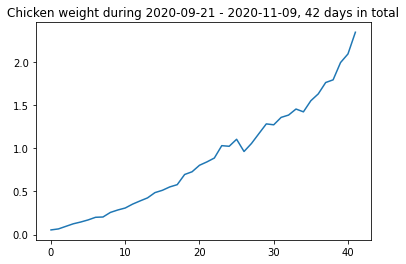

In [50]:
weight_21Sep = weight_21Sep.groupby("Date").mean().reset_index()
weight_21Sep = weight_21Sep.rename(columns={"Farm scale weight": "weight"})

weight_21Sep["weight"].plot()
plt.title("Chicken weight during 2020-09-21 - 2020-11-09, 42 days in total")


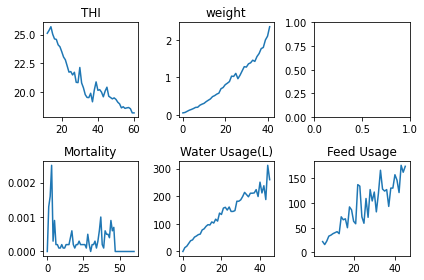

In [51]:
# for reference, growth trend
fig, axs = plt.subplots(2, 3)
f1_thi["THI"].plot(ax=axs[0,0])
axs[0, 0].set_title('THI')

input_21Sep["Mortality Rate"].plot(ax=axs[1,0])
axs[1,0].set_title('Mortality')

input_21Sep["Water Usage(L)"].plot(ax=axs[1,1])
axs[1, 1].set_title('Water Usage(L)')

input_21Sep["Feed Usage(grms/bird)"].plot(ax=axs[1,2])
axs[1,2].set_title('Feed Usage')

weight_21Sep["weight"].plot(ax=axs[0,1])
axs[0, 1].set_title('weight')


plt.tight_layout()

This data in summer, need another model/more generalised equation to summarise the overall behavior (regardless of season/taking different season into account(considersation) )

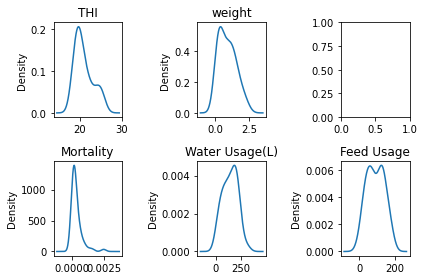

In [52]:
# kde, for reference
fig, axs = plt.subplots(2, 3)
f1_thi["THI"].plot.kde(ax=axs[0,0])
axs[0, 0].set_title('THI')

input_21Sep["Mortality Rate"].plot.kde(ax=axs[1,0])
axs[1,0].set_title('Mortality')

input_21Sep["Water Usage(L)"].plot.kde(ax=axs[1,1])
axs[1, 1].set_title('Water Usage(L)')

input_21Sep["Feed Usage(grms/bird)"].plot.kde(ax=axs[1,2])
axs[1,2].set_title('Feed Usage')

weight_21Sep["weight"].plot.kde(ax=axs[0,1])
axs[0, 1].set_title('weight')


plt.tight_layout()

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [53]:
# weight_21Sep=weight_21Sep.set_index("Date")
# weight_21Sep.index = weight_21Sep.index.swaplevel(0,1)

exog_21Sep = weight_21Sep.join([f1_thi["THI"], 
                       input_21Sep["Feed Usage(grms/bird)"],
                       input_21Sep["Water Usage(L)"]])

# import statsmodels as sm
# exog = sm.tools.tools.add_constant(exog_21Sep[["THI","Feed Usage(grms/bird)", "Water Usage(L)"]]) 
# #input_21Sep["Water Usage(L)"], input_21Sep["Feed Usage(grms/bird)"]
# mod = RandomEffects(weight_21Sep["weight"], exog)
# re_res = mod.fit()
# print(re_res)

In [54]:
exog_21Sep["THI"]= exog_21Sep["THI"].astype("float").round(1)


In [55]:

a = exog_21Sep.Date-exog_21Sep.Date[0]
exog_21Sep["numdays"] = pd.Series(a.dt.days.astype(int), index=exog_21Sep.index)
exog_21Sep= exog_21Sep.dropna()


In [56]:
exog_21Sep["activity"] = daily_activity[12:]


In [57]:
exog_21Sep.head()

,Date,weight,THI,Feed Usage(grms/bird),Water Usage(L),numdays,activity
12,2020-10-06,0.3902,25.1,42.0,91.0,13,25.756726
13,2020-10-07,0.4252,25.4,38.0,97.0,14,22.474335
14,2020-10-08,0.4864,25.7,72.0,96.0,15,21.836737
15,2020-10-09,0.5132,25.0,66.0,107.0,16,21.569797
16,2020-10-10,0.5526,24.6,68.0,103.0,17,26.175830


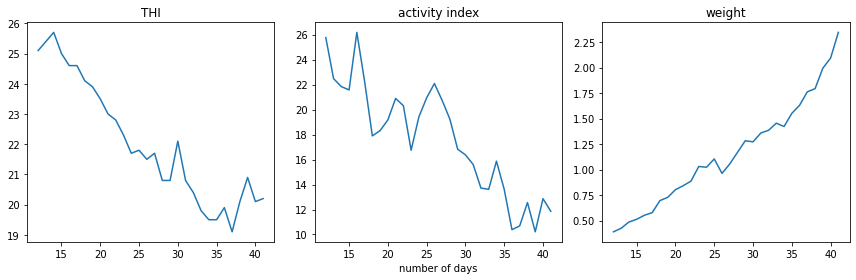

In [58]:
fig, axs = plt.subplots(1, 3,figsize=(12,4),sharex=True)
# fig.text(0.5, -0.01, 'number of days', ha='center')

exog_21Sep["THI"].plot(ax=axs[0])
axs[0].set_title('THI')

exog_21Sep["activity"].plot(ax=axs[1])
axs[1].set_title('activity index')

exog_21Sep["weight"].plot(ax=axs[2])
axs[2].set_title('weight')

axs[1].set_xlabel("number of days")

plt.tight_layout()
# plt.savefig("plot_all.png",facecolor='white', edgecolor='none')

In [59]:
exog_21Sep.to_csv("cleaned_data.csv")



# 3D plot for visualising dimensions of data 

## depedency: plotly (installed via magic commands)

In [67]:
%pip install plotly

     |████████████████████████████████| 21.8 MB 10.3 MB/s eta 0:00:01   |███                             | 2.1 MB 2.1 MB/s eta 0:00:10     |████▊                           | 3.2 MB 1.4 MB/s eta 0:00:14     |█████▌                          | 3.7 MB 3.1 MB/s eta 0:00:06     |████████████████████▍           | 13.9 MB 5.5 MB/s eta 0:00:02
Note: you may need to restart the kernel to use updated packages.


<IPython.core.display.Javascript object>

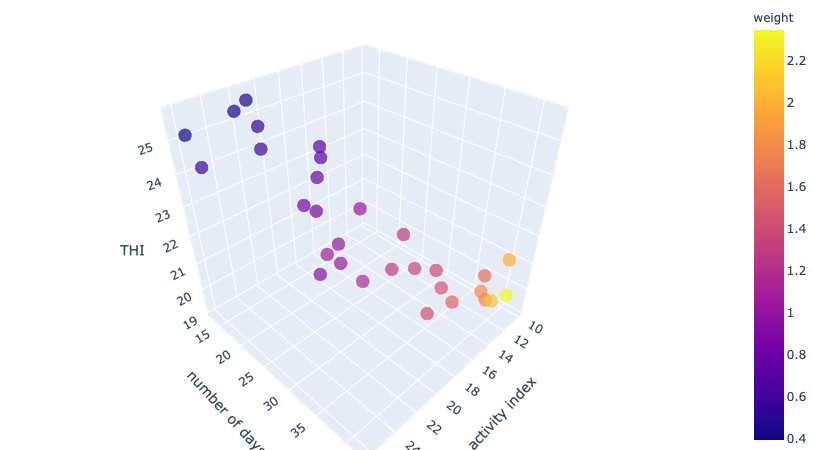

<IPython.core.display.Javascript object>

In [93]:
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.express as px

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

fig = px.scatter_3d(exog_21Sep, x='activity', y='numdays', z='THI',
              color='weight',
              opacity=0.7) #create 3d scatter plot


# tight layout
fig.update_layout(showlegend=True, #add legend
                  scene = dict(
                    xaxis_title='activity index',
                    yaxis_title='number of days',
                    zaxis_title='THI'),
                    width=700,
                    margin=dict(l=0, r=0, b=0, t=0)
                  )

fig.write_html("3D_scatter.html") #output the html file
fig.show()

### The rest is not implemented in this study
### because multilevel model is not apporpriate (dataset too small)
### This is kept because if we have more data (from another flock)
### this method is useful because it is good at longitudinal data (with each flock as one level/treatment)

- GLM(general linear model): 
Least squares means (+SE) and tests of significance of factors
doi:10.4314/jab.v67i0.95053 
y (weight) = ax1+bx2+cx3+...

Choice of model:

https://doi.org/10.1159/000330228

also
random regression model
why? DOI:10.1079/9780851990002.0000
page 71, "A more appropriate way of handling repeated measurements over time is by fitting a random regression model or a covariance function"

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

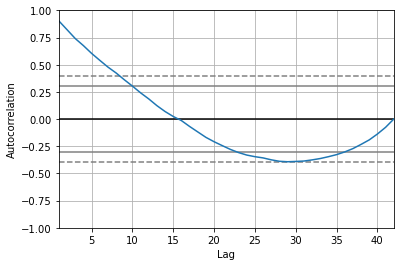

In [61]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(weight_21Sep.set_index("Date"))

In [34]:
!pip install linearmodels
from linearmodels import PanelOLS
from linearmodels import RandomEffects

In [35]:

import statsmodels.api as sm
import statsmodels.formula.api as smf


md = smf.mixedlm("weight ~ numdays", exog_21Sep, groups=exog_21Sep["THI"])

mdf = md.fit()

print(mdf.summary())

# mod = RandomEffects(data.clscrap, exog)



        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: weight 
No. Observations: 30      Method:             REML   
No. Groups:       24      Scale:              0.0057 
Min. group size:  1       Log-Likelihood:     18.8086
Max. group size:  3       Converged:          Yes    
Mean group size:  1.2                                
-----------------------------------------------------
           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------
Intercept  -0.444    0.066 -6.686 0.000 -0.574 -0.314
numdays     0.058    0.002 25.028 0.000  0.054  0.063
Group Var   0.005    0.094                           



/opt/conda/envs/sds2020/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Best degree 8 with RMSE 0.020411211455525602


Text(0, 0.5, 'RMSE')

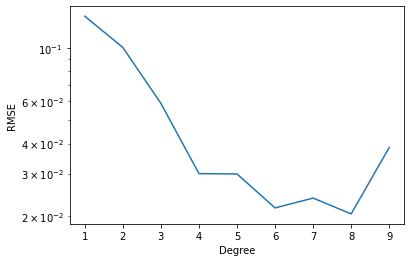

In [36]:
# ref
# https://stackoverflow.com/questions/47442102/how-to-find-the-best-degree-of-polynomials


# import numpy as np
# np.polynomial.polynomial.polyfit(exog_21Sep.numdays, exog_21Sep.weight, 4)

import numpy as np
import matplotlib.pyplot as plt 

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X = np.array(exog_21Sep.numdays).reshape(-1, 1)
y = exog_21Sep.weight

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

rmses = []
degrees = np.arange(1, 10)
min_rmse, min_deg = 1e10, 0

for deg in degrees:

    # Train features
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    x_poly_train = poly_features.fit_transform(x_train)

    # Linear regression
    poly_reg = LinearRegression()
    poly_reg.fit(x_poly_train, y_train)

    # Compare with test data
    x_poly_test = poly_features.fit_transform(x_test)
    poly_predict = poly_reg.predict(x_poly_test)
    poly_mse = mean_squared_error(y_test, poly_predict)
    poly_rmse = np.sqrt(poly_mse)
    rmses.append(poly_rmse)
    
    # Cross-validation of degree
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg

# Plot and present results
print('Best degree {} with RMSE {}'.format(min_deg, min_rmse))
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(degrees, rmses)
ax.set_yscale('log')
ax.set_xlabel('Degree')
ax.set_ylabel('RMSE')


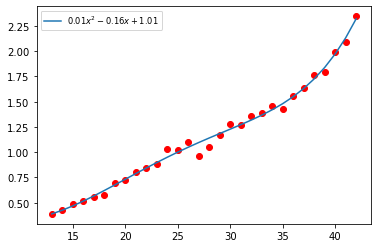

In [37]:
from sympy import S, symbols, printing

X = exog_21Sep.numdays

p = np.polyfit(X, y, 5)
f = np.poly1d(p)

# calculate new x's and y's
x_new = X
y_new = f(x_new)

x = symbols("x")
poly = sum(S("{:6.2f}".format(v))*x**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)

plt.plot(x_new, y_new, label="${}$".format(eq_latex))
plt.scatter(X, y, color='r')
plt.legend(fontsize="small")
plt.show()

best fit of time to weight explains 96% percent of variance. 


2-way interaction:
e.g., only look at THI/activity(separately), might not have effect on response
but if big THI promote activity, 

Reference:

1. fix activity data corruption using polyfit, link [here](https://stackoverflow.com/questions/47442102/how-to-find-the-best-degree-of-polynomials)


